In [1]:
%run ./utility_functions.ipynb

2025-04-25 18:48:52.856364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 18:48:52.967932: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 18:48:53.652234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cdiop/.conda/envs/perso/lib:/lib
2025-04-25 18:48:53.652297: W tensorflow/compile

Number of logical CPU cores: 48


In [2]:
strategy = tf.distribute.MirroredStrategy(devices = ["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"])

2025-04-25 18:48:57.892486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-25 18:48:57.895010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-25 18:48:57.897511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-25 18:48:57.900007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-25 18:48:57.909082: I tensorflow/compiler/xla/stream_executo

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


# Load Dataset

In [3]:
image_shape = (128,128,3)

In [4]:
train_dataset_path = "../Dataset/clean/TensorflowFaces/"
valid_dataset_path = "../Dataset/clean/TensorflowFaces_test/"

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

trainLoader = Loader(path=train_dataset_path,
                     image_shape=image_shape,
                     batch_size=BATCH_SIZE,
                     max_pos_pairs= 800000,
                     apply_augmentation=False,
                     augmentation_pourcentage=0.5,
                     preprocess_pipeline = None,
                     normalize = True,
                     image_per_celeb=25)

training_dataset = trainLoader.dataset

validLoader = Loader(path=valid_dataset_path,
                     image_shape=image_shape,
                     batch_size=BATCH_SIZE,
                     max_pos_pairs=5000,
                     preprocess_pipeline=None,
                     normalize=True)

validation_dataset = validLoader.dataset

created pos pair
created neg pairs
Number of positive pairs: 800000
Number of negative pairs: 800000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Used 9440/9759 distinct classes for positve pairs
Used 9759/9759 distinct classes for negative pairs
created pos pair
created neg pairs
Number of positive pairs: 5000
Number of negative pairs: 5000
Used 353/400 distinct classes for positve pairs
Used 400/400 distinct classes for negative pairs


2025-04-18 01:37:48.506388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193543 of 250000
2025-04-18 01:37:50.723992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


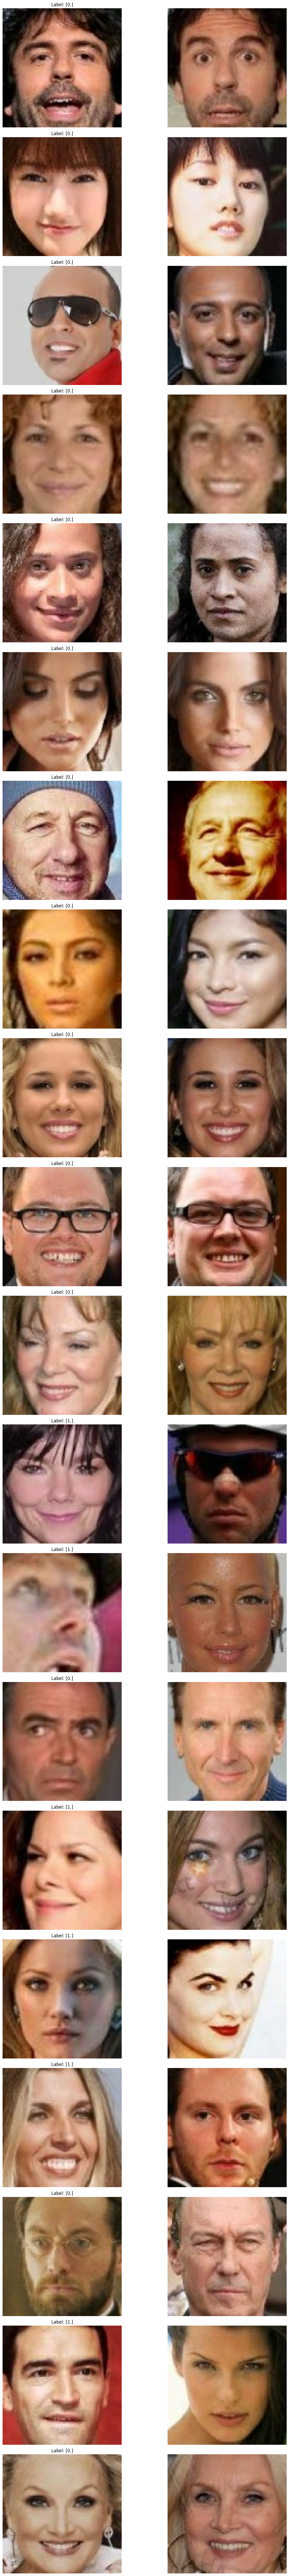

In [5]:
trainLoader.visualize(value_range=(0,1),
                      color_mode_switch=False)

# Training

## MobileNet

In [5]:
model_name = "feature_extractor_3"

In [6]:
log_dir = f"../runs/{model_name}_{datetime.now().strftime('%Y%m%d=%H%M%S')}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,        
    histogram_freq=1,         
    write_graph=False,         
    write_images=False         
)

activation_callb = actionCallback(training_dataset,validation_dataset, log_dir, BATCH_SIZE)

with strategy.scope(): 
    
    optimizer = Adam(learning_rate=1e-4)
    # optimizer = SGD(learning_rate=1e-2, momentum=0.999, nesterov=False)
    
    distance_fc = similarityDistances(normalize=True).euclidean_distance
    loss_fc = contrastiveLoss(margin=0.5, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, distance_fc=distance_fc, hard_mining=False)
    
    dist_sim_metric = Distance(name="sim_distance_metric", aggregation_method="quartil", mode=0, distance_fc = distance_fc)
    dist_dissim_metric = Distance(name="dissim_distance_metric", aggregation_method="quartil", mode=1, distance_fc = distance_fc)
    
    acc = Accuracy(threshold=0.5, name="accuraccy", distance_fc = distance_fc)
    
    feature_extractor = get_feature_extractor_3(l2reg=1e-4)
    # feature_extractor = Xception(include_top=False, input_shape=image_shape)
    

    s_network = siameseNetwork(input_size=image_shape, base_model=feature_extractor, embedding_dimension = 32, dropout=0.2, l2_reg=1e-4, name="siamese", apply_augmentation=False)
    print(s_network.base_model.summary())

    s_network.compile(optimizer=optimizer,
                      loss = loss_fc,
                      metrics = [dist_sim_metric, dist_dissim_metric, acc])
    
    s_network.fit(training_dataset, epochs=15, validation_data=validation_dataset, callbacks=[tensorboard_callback, activation_callb])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-04-25 18:50:23.622265: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1600000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
 

Epoch 1/15
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1


2025-04-25 18:50:50.297819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14847 of 250000
2025-04-25 18:51:00.587649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 29585 of 250000
2025-04-25 18:51:10.303610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47743 of 250000
2025-04-25 18:51:20.723373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 70609 of 250000
2025-04-25 18:51:30.296517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 101401 of 250000
2025-04-25 18:51:40.498390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 157657 of 250000
2025-04-25 18:51:47.834181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc

12500/12500 [==============================] - ETA: 0s - loss: 0.0066 - sim_distance_metric: 0.1798 - dissim_distance_metric: 0.2682 - accuraccy: 0.8234

2025-04-25 19:22:05.658448: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
   

12500/12500 [==============================] - 1937s 147ms/step - loss: 0.0066 - sim_distance_metric: 0.1798 - dissim_distance_metric: 0.2682 - accuraccy: 0.8234 - val_loss: 0.0336 - val_sim_distance_metric: 0.4082 - val_dissim_distance_metric: 0.5267 - val_accuraccy: 0.8553
Epoch 2/15
12500/12500 [==============================] - 1843s 147ms/step - loss: 0.0050 - sim_distance_metric: 0.1583 - dissim_distance_metric: 0.2868 - accuraccy: 0.8492 - val_loss: 0.0316 - val_sim_distance_metric: 0.3967 - val_dissim_distance_metric: 0.5534 - val_accuraccy: 0.8784
Epoch 3/15
12500/12500 [==============================] - 1844s 147ms/step - loss: 0.0045 - sim_distance_metric: 0.1519 - dissim_distance_metric: 0.2979 - accuraccy: 0.8617 - val_loss: 0.0293 - val_sim_distance_metric: 0.3804 - val_dissim_distance_metric: 0.5559 - val_accuraccy: 0.8780
Epoch 4/15
12500/12500 [==============================] - 1845s 147ms/step - loss: 0.0042 - sim_distance_metric: 0.1469 - dissim_distance_metric: 0.30

#  Evaluating

In [ ]:
with strategy.scope():
    
    optimizer = Adam(learning_rate=1e-4)
    
    distance_fc = similarityDistances(normalize=False).euclidean_distance
    loss_fc = contrastiveLoss(margin=1.0, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, distance_fc=distance_fc, hard_mining=False)
    
    dist_sim_metric = Distance(name="sim_distance_metric", aggregation_method="quartil", mode=0, distance_fc = distance_fc)
    dist_dissim_metric = Distance(name="dissim_distance_metric", aggregation_method="quartil", mode=1, distance_fc = distance_fc)
    
    acc = Accuracy(threshold=0.55, name="accuraccy",distance_fc = distance_fc)
    # acc = BinaryAccuracy(threshold = 0.5)
    
    s_network.compile(optimizer=optimizer,
                      loss = loss_fc,
                      metrics = [dist_sim_metric, dist_dissim_metric, acc])
    
    s_network.evaluate(validation_dataset)